# Import

In [1]:
import os, joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Concatenate, Input

from sklearn.linear_model import LogisticRegression

In [2]:
current = os.getcwd()
os.chdir('../modelEval')

In [3]:
from scripts.evalModel import precision, getPredDist, countDrugsK

In [4]:
os.chdir(current)

# Load Data 

## RNA

In [5]:
trainRNA = pd.read_csv('../../data/processed/RNA_train_cancergenes.csv', index_col=0)
valRNA = pd.read_csv('../../data/processed/RNA_val_cancergenes.csv', index_col=0)
testRNA = pd.read_csv('../../data/processed/RNA_test_cancergenes.csv', index_col=0)
newRNA = pd.read_csv('../../data/processed/RNA_newcancer_cancergenes.csv', index_col=0)

## Drugs

In [6]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## CDR

In [7]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
cdrFilt = cdr.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'ic50', 'auc', 'lower_limit', 'effectiveCont', 'effective']]
cdrFilt.rename(columns={'DepMap_ID': 'cell_line', 'name': 'drug', 'effective': 'true'}, inplace=True)
cdrFilt.head()

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,0.105140,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,0.099077,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,0.060055,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,0.390028,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,0.236216,3.801377,0


# Process data

## Combine RNA

In [8]:
allRNA = pd.concat([trainRNA, valRNA])
allRNA.shape

(300, 463)

# Make result dfs

In [9]:
rows = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
cols = ['p1', 'p2', 'p3', 'p4', 'p5', 'p10', 'nWrong', 'nUnique', 'variance']

In [10]:
clTest = pd.DataFrame(index=rows, columns=cols)
clNew = pd.DataFrame(index=rows, columns=cols)

ctTest = pd.DataFrame(index=rows, columns=cols[:5])
ctNew = pd.DataFrame(index=rows, columns=cols[:5])

# Define

## model creation functions

In [11]:
def loadEncoder(path, which='rna'):
    try:
        snn = load_model(path)
        encoder = snn.get_layer('model')
        encoder._name = f'{which}Encoder'
        return encoder
    except AttributeError:
        return None
    
def getModel(rnaPath=None, drugPath=None, rnaDim=463, drugDim=256):
        # Define encoded drug input
        drugInput = Input(drugDim)
        rnaInput = Input(rnaDim)
                                             
        if drugPath == None:
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugInput, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugInput, rnaEmbed])
        else:
            drugEmbed = loadEncoder(drugPath, which='drug')(drugInput)
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugEmbed, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugEmbed, rnaEmbed])

        return Model(inputs=[drugInput, rnaInput], outputs=pairEmbed)

## visualization functions

In [12]:
def minMaxNorm(series):
    return (series - series.min()) / (series.max() - series.min())


def vizImportance(series, drugColor='#377eb8', cellColor='#e41a1c', norm=True):
    # process series / importance data
    if norm:
        series = minMaxNorm(series)
    series = series[series > 0.0].sort_values(ascending=False)
    
    # define bar colors
    colors = []
    for idx in series.index:
        if idx.startswith('drug'):
            colors.append(drugColor)
        else:
            colors.append(cellColor)
    
    # plot feature importance
    plt.figure(figsize=(20, 10))
    bars = plt.bar(series.index, series.values, color=colors)
    
    # plot avg importance by feature type
    avgCellImportance = series[series.index.str.startswith('cell')].mean()
    avgCellLine = plt.axhline(avgCellImportance, color=cellColor,
                linestyle='dashed', linewidth=3, label='Avg relative cell line feature importance')
    
    avgDrugImportance = series[series.index.str.startswith('drug')].mean()
    avgDrugLine = plt.axhline(avgDrugImportance, color=drugColor, 
                linestyle='dashed', linewidth=3, label='Avg relative drug feature importance')

    
    # create legend
    drugLeg = mpatches.Patch(color=drugColor, label='Drug features')
    cellLeg = mpatches.Patch(color=cellColor, label='Cell line features')
    plt.legend(handles=[drugLeg, cellLeg, avgDrugLine, avgCellLine], loc=1, fontsize=20)
    
    # format plot
    plt.xlim([0-0.5,len(series)-0.5])
    plt.xticks([])
    plt.ylim([0.0,1.0])
    plt.yticks([0, 1], fontsize=20)
    plt.show()

## paths

In [13]:
# drugPath = '../../models/drugEncoders/'
# drugPath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/drugs/siameseV1/models/'
# drugModel = 'DrugFewShot_Layers1_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
# drugPath = os.path.join(drugPath, drugModel)
drugPath=None

In [14]:
# rnaPath = '../../models/cellEncoders/'
# rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = '/fs/scratch/PCON0041/PatrickLawrence/cancer-drug-response/fewShot/cellLines/siameseV1/models/'
rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFsigmoid_LR0-001_DR0-99_DS1000'
rnaPath = os.path.join(rnaPath, rnaModel)

## Encoder model

In [15]:
encoder = getModel(rnaPath, drugPath)

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [16]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 463)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 rnaEncoder (Functional)        (None, 64)           38016       ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 320)          0           ['input_1[0][0]',                
                                                                  'rnaEncoder[2][0]']         

# 5-fold CV

## encoder newcancer data

In [23]:
testCDR = cdrFilt[cdrFilt.cell_line.isin(testRNA.index)]

testData = encoder([drugs.loc[list(testCDR.drug.values), :].to_numpy(), 
                    testRNA.loc[list(testCDR.cell_line.values), :].to_numpy()]).numpy()

newCDR = cdrFilt[cdrFilt.cell_line.isin(newRNA.index)]

newData = encoder([drugs.loc[list(newCDR.drug.values), :].to_numpy(), 
                   newRNA.loc[list(newCDR.cell_line.values), :].to_numpy()]).numpy()

## Load folds

In [18]:
foldDF = pd.read_csv('../../data/processed/cellLinesForCV.csv')
foldDF.head()

,fold0,fold1,fold2,fold3,fold4
0,ACH-000741,ACH-000026,ACH-000720,ACH-000566,ACH-000890
1,ACH-000396,ACH-000753,ACH-000018,ACH-000011,ACH-000845
2,ACH-000839,ACH-000973,ACH-000905,ACH-000142,ACH-000875
3,ACH-000273,ACH-000231,ACH-000558,ACH-000756,ACH-000869
4,ACH-000323,ACH-000137,ACH-000469,ACH-000232,ACH-000572


## run

In [26]:
cdrFilt

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,3.801377,0
...,...,...,...,...,...,...,...
67784,ACH-001321,Thyroid Cancer,gambogic-acid,0.292873,0.698090,2.580958,0
67785,ACH-001321,Thyroid Cancer,carfilzomib,0.003318,0.458009,6.591288,0
67786,ACH-001321,Thyroid Cancer,belinostat,0.758857,0.773007,2.074442,0
67787,ACH-001321,Thyroid Cancer,resminostat,0.684318,0.733681,2.320502,0


In [19]:
models = {}
np.random.seed(5)
for f in foldDF.columns:
    print(f)
    # get cell lines to use in test fold
    testCellLines = list(foldDF[f])
    trainCellLines = list(foldDF.drop(f, axis=1).to_numpy().reshape(-1))
    
    # split data into test and train sets
    testCDR = cdrFilt[cdrFilt.cell_line.isin(testCellLines)].copy()
    trainCDR = cdrFilt[cdrFilt.cell_line.isin(trainCellLines)].copy()
    
    # get raw RNA + Drug data
    trainData = encoder([drugs.loc[list(trainCDR.drug), :].to_numpy(), 
                         allRNA.loc[list(trainCDR.cell_line), :].to_numpy()]).numpy()
    
    testData = encoder([drugs.loc[list(testCDR.drug), :].to_numpy(), 
                        allRNA.loc[list(testCDR.cell_line), :].to_numpy()]).numpy()
    
    # Get GT labels for train Data
    trainEff = trainCDR.true.to_numpy()
    
    
    model = LogisticRegression()
    model.fit(trainData, trainEff)
    
    # Test results (cell line)
    testPreds = testCDR.copy()
    testPreds['pred'] = [p[1] for p in model.predict_proba(testData)]
    testPreds.sort_values(by='pred', ascending=False, inplace=True)
    testCount, testWrong = countDrugsK(testPreds)
    clTest.loc[f, :] = precision(testPreds, thresh=0.1, at=1, by='cellLine', getResults=True) +\
                        [len(testWrong), len(testCount), round(testPreds.groupby('drug').pred.var().mean(),4)]
    
    # Test results (cancer)
    ctTest.loc[f, :] = list(precision(testPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # New cancer results
    newPreds = newCDR.copy()
    newPreds['pred'] = [p[1] for p in model.predict_proba(newData)]
    newPreds.sort_values(by='pred', ascending=False, inplace=True)
    newCount, newWrong = countDrugsK(newPreds)
    newPrecision = precision(newPreds, thresh=0.1, at=1, by='cellLine', getResults=True)
    clNew.loc[f, :] =  newPrecision +\
                        [len(newWrong), len(newCount), round(newPreds.groupby('drug').pred.var().mean(),4)]
    
    # New cancer results (cancer)
    ctNew.loc[f, :] = list(precision(newPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # Keep model
    models[f] = model


# cell line test
clTest.loc['mean', :] = clTest.iloc[:5,:].mean()
clTest.loc['std', :] = clTest.iloc[:5,:].std()
clTest.iloc[:, :6] = clTest.iloc[:, :6].astype(float).round(4)

# cancer test
ctTest.loc['mean', :] = ctTest.iloc[:5,:].mean()
ctTest.loc['std', :] = ctTest.iloc[:5,:].std()
ctTest = ctTest.astype(float).round(4)

# cell line new
clNew.loc['mean', :] = clNew.iloc[:5,:].mean()
clNew.loc['std', :] = clNew.iloc[:5,:].std()
clNew.iloc[:, :6] = clNew.iloc[:, :6].astype(float).round(4)

# cancer new
ctNew.loc['mean', :] = ctNew.iloc[:5,:].mean()
ctNew.loc['std', :] = ctNew.iloc[:5,:].std()
ctNew = ctNew.astype(float).round(4)

fold0


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Precision@1: 0.9492
	Precision@2: 0.9322
	Precision@3: 0.9096
	Precision@4: 0.8856
	Precision@5: 0.861
	Precision@10: 0.7918

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9538
	Precision@2: 0.9154
	Precision@3: 0.9128
	Precision@4: 0.8692
	Precision@5: 0.8585
	Precision@10: 0.802

fold1


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Precision@1: 0.9298
	Precision@2: 0.9298
	Precision@3: 0.924
	Precision@4: 0.8904
	Precision@5: 0.8737
	Precision@10: 0.7731

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9385
	Precision@2: 0.9077
	Precision@3: 0.8974
	Precision@4: 0.8615
	Precision@5: 0.8585
	Precision@10: 0.802

fold2


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Precision@1: 0.9298
	Precision@2: 0.9211
	Precision@3: 0.9064
	Precision@4: 0.8596
	Precision@5: 0.8386
	Precision@10: 0.8085

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9538
	Precision@2: 0.9154
	Precision@3: 0.9077
	Precision@4: 0.8769
	Precision@5: 0.8646
	Precision@10: 0.8059

fold3


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Precision@1: 0.9828
	Precision@2: 0.9655
	Precision@3: 0.9483
	Precision@4: 0.8879
	Precision@5: 0.8793
	Precision@10: 0.8283

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9538
	Precision@2: 0.9154
	Precision@3: 0.9077
	Precision@4: 0.8846
	Precision@5: 0.8615
	Precision@10: 0.8137

fold4


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Precision@1: 0.9677
	Precision@2: 0.9355
	Precision@3: 0.9086
	Precision@4: 0.8911
	Precision@5: 0.8677
	Precision@10: 0.802

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
	Precision@1: 0.9538
	Precision@2: 0.9077
	Precision@3: 0.8974
	Precision@4: 0.8769
	Precision@5: 0.8677
	Precision@10: 0.8059



# Results

## Test set 

In [20]:
clTest

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9492,0.9322,0.9096,0.8856,0.861,0.7918,0,10,0.0
fold1,0.9298,0.9298,0.924,0.8904,0.8737,0.7731,0,13,0.0
fold2,0.9298,0.9211,0.9064,0.8596,0.8386,0.8085,0,10,0.0
fold3,0.9828,0.9655,0.9483,0.8879,0.8793,0.8283,0,12,0.0
fold4,0.9677,0.9355,0.9086,0.8911,0.8677,0.802,0,11,0.0
mean,0.9519,0.9368,0.9194,0.8829,0.8641,0.8007,0.0,11.2,0.0
std,0.0234,0.0169,0.0176,0.0132,0.0158,0.0204,0.0,1.30384,0.0


In [21]:
# cancer
ctTest

,p1,p2,p3,p4,p5
fold0,0.9347,0.9326,0.9019,0.8781,0.8500
fold1,0.9613,0.9573,0.9372,0.8954,0.8704
fold2,0.9347,0.9090,0.9028,0.8611,0.8353
fold3,0.9833,0.9699,0.9470,0.8897,0.8792
fold4,0.9714,0.9487,0.9010,0.8857,0.8638
mean,0.9571,0.9435,0.9179,0.8820,0.8597
std,0.0219,0.0236,0.0223,0.0133,0.0173


## New cancer set 

In [22]:
clNew

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9538,0.9154,0.9128,0.8692,0.8585,0.802,1,14,0.0001
fold1,0.9385,0.9077,0.8974,0.8615,0.8585,0.802,1,16,0.0001
fold2,0.9538,0.9154,0.9077,0.8769,0.8646,0.8059,1,13,0.0001
fold3,0.9538,0.9154,0.9077,0.8846,0.8615,0.8137,1,15,0.0001
fold4,0.9538,0.9077,0.8974,0.8769,0.8677,0.8059,1,14,0.0
mean,0.9508,0.9123,0.9046,0.8738,0.8622,0.8059,1.0,14.4,0.00008
std,0.0069,0.0042,0.0069,0.0088,0.004,0.0048,0.0,1.140175,0.000045


In [23]:
ctNew

,p1,p2,p3,p4,p5
fold0,0.9646,0.9285,0.9256,0.8758,0.8443
fold1,0.9521,0.9333,0.9226,0.8717,0.8474
fold2,0.9646,0.9285,0.9305,0.8823,0.8523
fold3,0.9646,0.9285,0.9305,0.8917,0.8534
fold4,0.9646,0.9229,0.9242,0.8892,0.8548
mean,0.9621,0.9283,0.9267,0.8821,0.8504
std,0.0056,0.0037,0.0036,0.0085,0.0044


# Save CV results

In [24]:
clTest.to_csv('../../data/results/rawDrugEmbedCellConcatLogistic-cellLineTest.csv', index=False)
ctTest.to_csv('../../data/results/rawDrugEmbedCellConcatLogistic-cancerTest.csv', index=False)
clNew.to_csv('../../data/results/rawDrugEmbedCellConcatLogistic-cellLineNew.csv', index=False)
ctNew.to_csv('../../data/results/rawDrugEmbedCellConcatLogistic-cancerNew.csv', index=False)

# Examine preds

In [33]:
newPreds[newPreds.cell_line == 'ACH-000268']

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true,pred
18548,ACH-000268,Bile Duct Cancer,sangivamycin,0.209997,0.146064,0.062506,4.692792,0,0.528026
50315,ACH-000268,Bile Duct Cancer,BGT226,0.131253,0.558484,0.012776,5.927107,0,0.485014
59552,ACH-000268,Bile Duct Cancer,rubitecan,0.022811,0.459721,0.147667,5.315568,0,0.460105
19277,ACH-000268,Bile Duct Cancer,epothilone-d,0.031756,0.435622,0.211304,4.754373,0,0.385103
60530,ACH-000268,Bile Duct Cancer,verubulin,0.006034,0.527347,0.407113,5.894469,0,0.377252
23813,ACH-000268,Bile Duct Cancer,delanzomib,0.070964,0.495877,0.019581,6.053362,0,0.198359
48063,ACH-000268,Bile Duct Cancer,GSK2126458,0.071026,0.505074,0.062650,4.956558,0,0.180307
60769,ACH-000268,Bile Duct Cancer,VE-822,0.079767,0.513173,0.029019,5.567548,0,0.126803
57565,ACH-000268,Bile Duct Cancer,LY2606368,0.107362,0.571670,0.090634,4.236721,0,0.106399
55837,ACH-000268,Bile Duct Cancer,CGS-15943,0.360996,0.684319,0.148554,2.789079,0,0.093201


In [34]:
newPreds[newPreds.drug == 'sangivamycin']

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true,pred
18495,ACH-000172,Rhabdoid,sangivamycin,43.900326,0.018646,0.014969,7.491515,1,0.553810
18535,ACH-000903,Thyroid Cancer,sangivamycin,0.015919,0.025177,0.018044,8.316005,1,0.528028
18528,ACH-000880,Gastric Cancer,sangivamycin,0.023860,0.036765,0.025282,7.568780,1,0.528027
18548,ACH-000268,Bile Duct Cancer,sangivamycin,0.209997,0.146064,0.062506,4.692792,0,0.528026
18489,ACH-000391,Bone Cancer,sangivamycin,0.079410,0.028722,0.025635,7.042220,0,0.528026
18526,ACH-000898,Gastric Cancer,sangivamycin,0.048649,0.066583,0.058299,6.130048,0,0.528025
18547,ACH-000674,Gastric Cancer,sangivamycin,0.079040,0.019859,0.016348,7.716697,1,0.528025
18497,ACH-000456,Thyroid Cancer,sangivamycin,0.071472,0.038773,0.033796,6.645105,0,0.528024
18584,ACH-000344,Gastric Cancer,sangivamycin,0.161697,0.052471,0.008232,7.372862,1,0.528023
18520,ACH-000411,Kidney Cancer,sangivamycin,0.060894,0.037786,0.021841,7.089327,0,0.528022


# Save models

In [35]:
basePath = '../../models/fsCDR/LogReg/'
for fold, model in models.items():
    outpath = os.path.join(basePath, f'RawDrug-EmbedCell-Concat-LM-CV{fold}.joblib')
    joblib.dump(model, outpath, compress=3)

# Load model

In [19]:
basePath = '../../models/fsCDR/LogReg/'
modelPath = os.path.join(basePath, 'RawDrug-EmbedCell-Concat-LM-CVfold3.joblib')
lm = joblib.load(modelPath)

In [27]:
# add test preds
testCDR['pred'] = [p[1] for p in lm.predict_proba(testData)]
testPreds = testCDR.sort_values(by='pred', ascending=False)

<ipython-input-27-f61e189f5203>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCDR['pred'] = [p[1] for p in lm.predict_proba(testData)]


In [29]:
testCancerResults = precision(testPreds, thresh=0.1, by='cancer')
testCancerResults.loc['Overall', :] = testCancerResults.mean(axis=0)
round(testCancerResults, 4)

,p1,p2,p3,p4,p5
Bladder Cancer,1.0000,1.0000,1.0000,1.0000,1.0000
Brain Cancer,1.0000,0.8750,0.8333,0.7500,0.7500
Breast Cancer,1.0000,1.0000,0.7778,0.8333,0.8000
Colon/Colorectal Cancer,1.0000,1.0000,0.9167,0.9375,0.9000
Endometrial/Uterine Cancer,1.0000,1.0000,0.8889,0.9167,0.8667
Esophageal Cancer,0.6667,0.8333,0.8889,0.7500,0.8000
Head and Neck Cancer,1.0000,1.0000,0.8889,0.8333,0.8000
Liver Cancer,1.0000,1.0000,1.0000,1.0000,1.0000
Lung Cancer,0.9231,0.8846,0.8718,0.9038,0.8462
Ovarian Cancer,1.0000,0.8750,0.8333,0.8125,0.8500


In [31]:
newCDR['pred'] = [p[1] for p in lm.predict_proba(newData)]
newPreds = newCDR.sort_values(by='pred', ascending=False)

<ipython-input-31-64ccf12e1955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR['pred'] = [p[1] for p in lm.predict_proba(newData)]


In [32]:
newCancerResults = precision(newPreds, thresh=0.1, by='cancer')
newCancerResults.loc['Overall', :] = newCancerResults.mean(axis=0)
round(newCancerResults, 4)

,p1,p2,p3,p4,p5
Bile Duct Cancer,0.8000,0.8000,0.8667,0.8500,0.8000
Bone Cancer,1.0000,0.9444,0.8889,0.8611,0.8667
Gallbladder Cancer,1.0000,1.0000,1.0000,0.7500,0.6000
Gastric Cancer,1.0000,1.0000,1.0000,0.9643,0.9429
Kidney Cancer,0.8462,0.7692,0.7436,0.7308,0.7077
Neuroblastoma,1.0000,0.8333,0.8889,0.9167,0.9333
Prostate Cancer,1.0000,1.0000,1.0000,1.0000,0.9000
Rhabdoid,1.0000,1.0000,1.0000,0.9375,0.9500
Sarcoma,1.0000,1.0000,1.0000,1.0000,0.9333
Thyroid Cancer,1.0000,0.9375,0.9167,0.9062,0.9000


In [38]:
feature_names = [f"drugFT{i}" for i in range(256)]
feature_names.extend([f"cellFT{i}" for i in range(64)])
importances = lm.coef_.reshape(-1)

In [39]:
lmImportance = pd.Series(importances, index=feature_names).apply(np.abs)

<ipython-input-12-5c2e99bd4072>:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


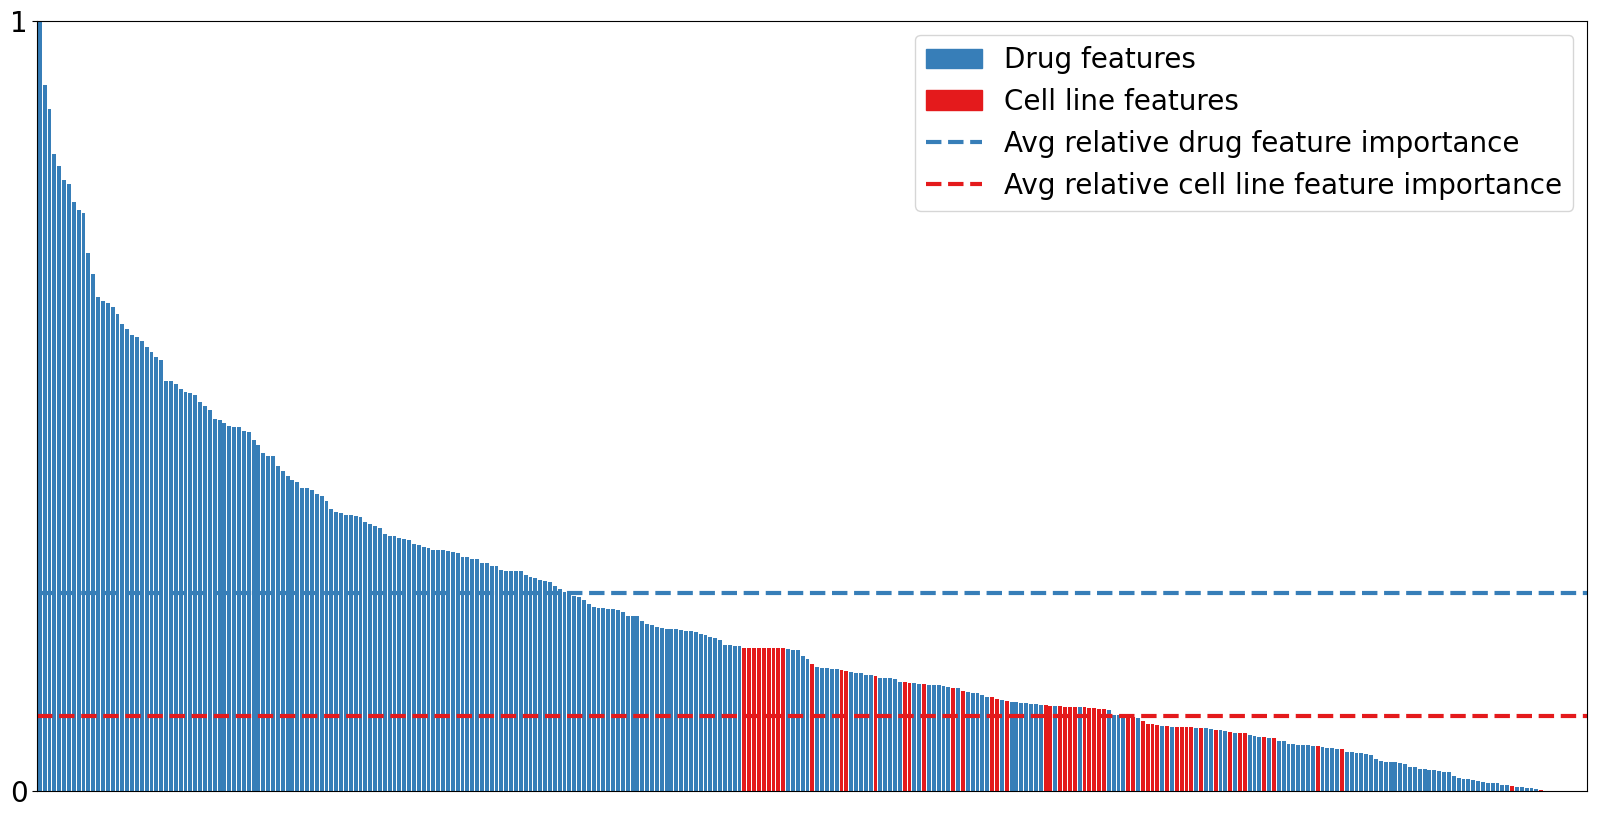

In [40]:
vizImportance(lmImportance)

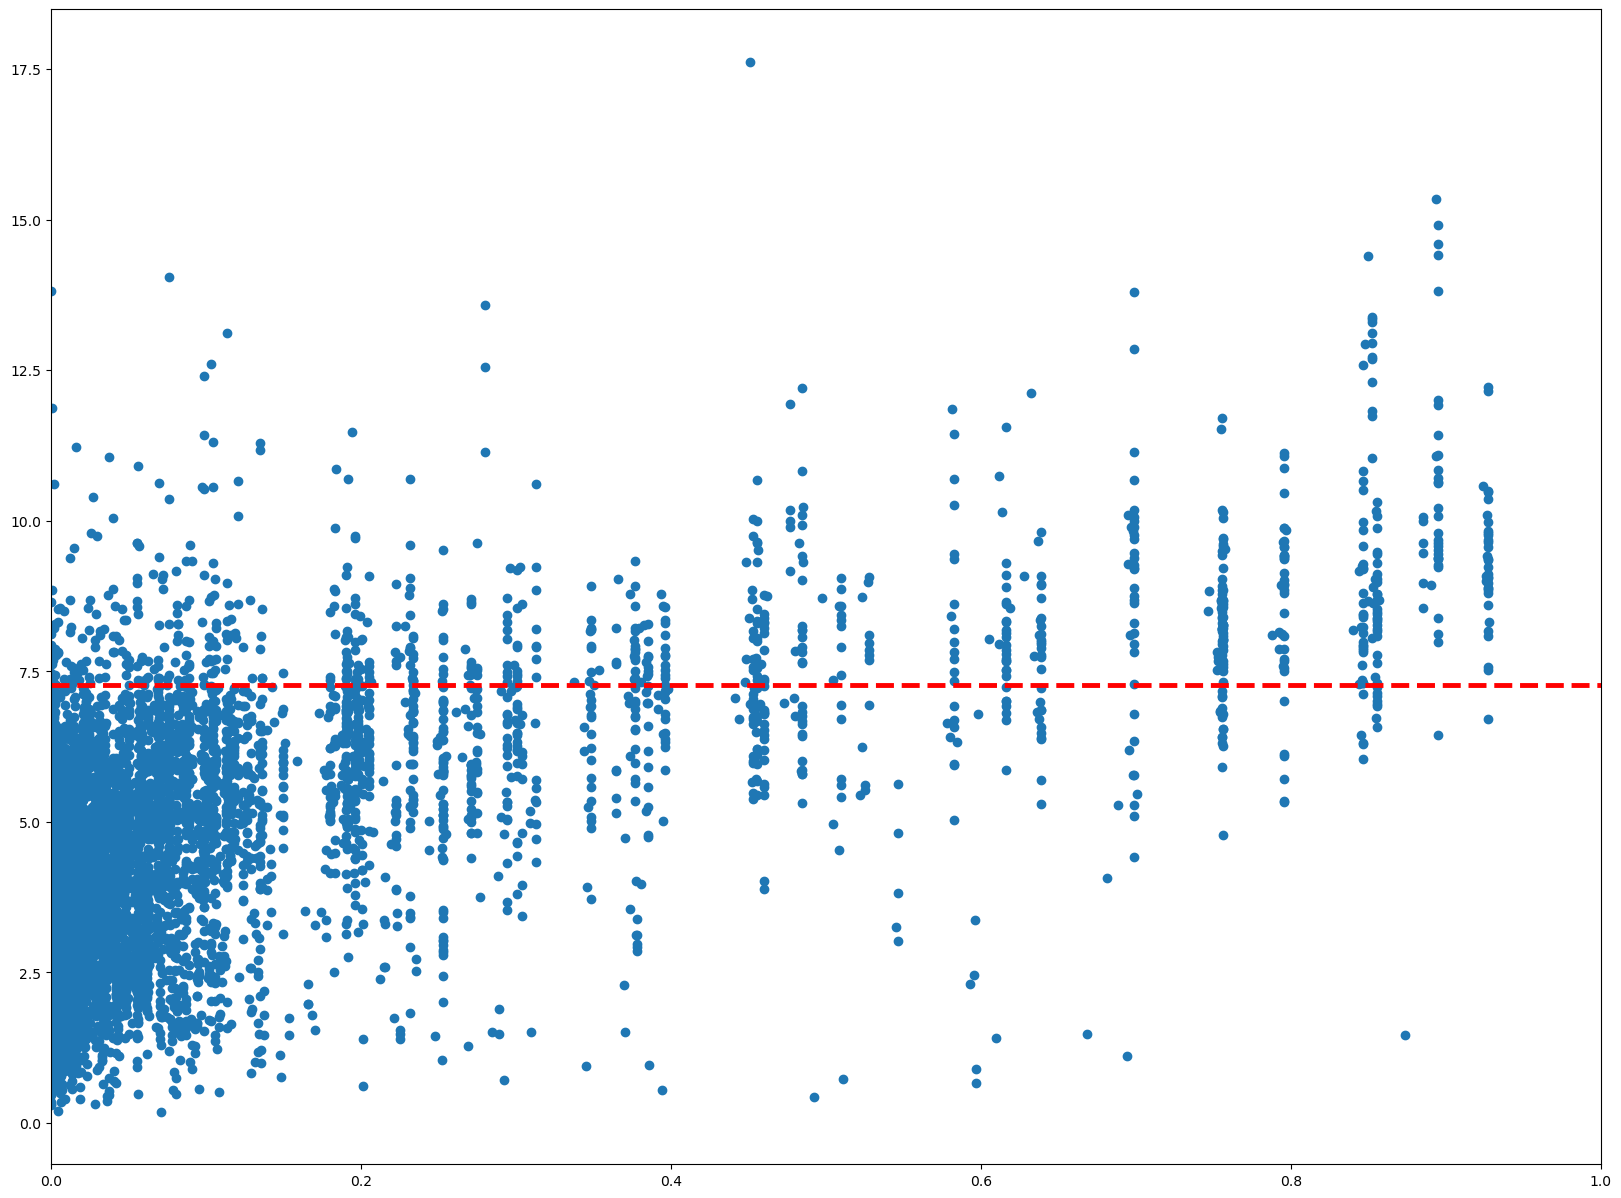

In [41]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=testCDR.effectiveCont)
plt.axhline(7.2734, color='red', linestyle='dashed', linewidth=3.5)
plt.xlim([0,1])
plt.show()

In [42]:
len(set(testCDR[testCDR.pred >= 0.5].drug))

29

In [43]:
len(set(testCDR[(testCDR.pred >= 0.5) & (testCDR.true == 1)].drug))

16

In [44]:
testCDR[testCDR.pred > 0.5].true.sum() / len(testCDR[testCDR.pred > 0.5])

0.7748917748917749

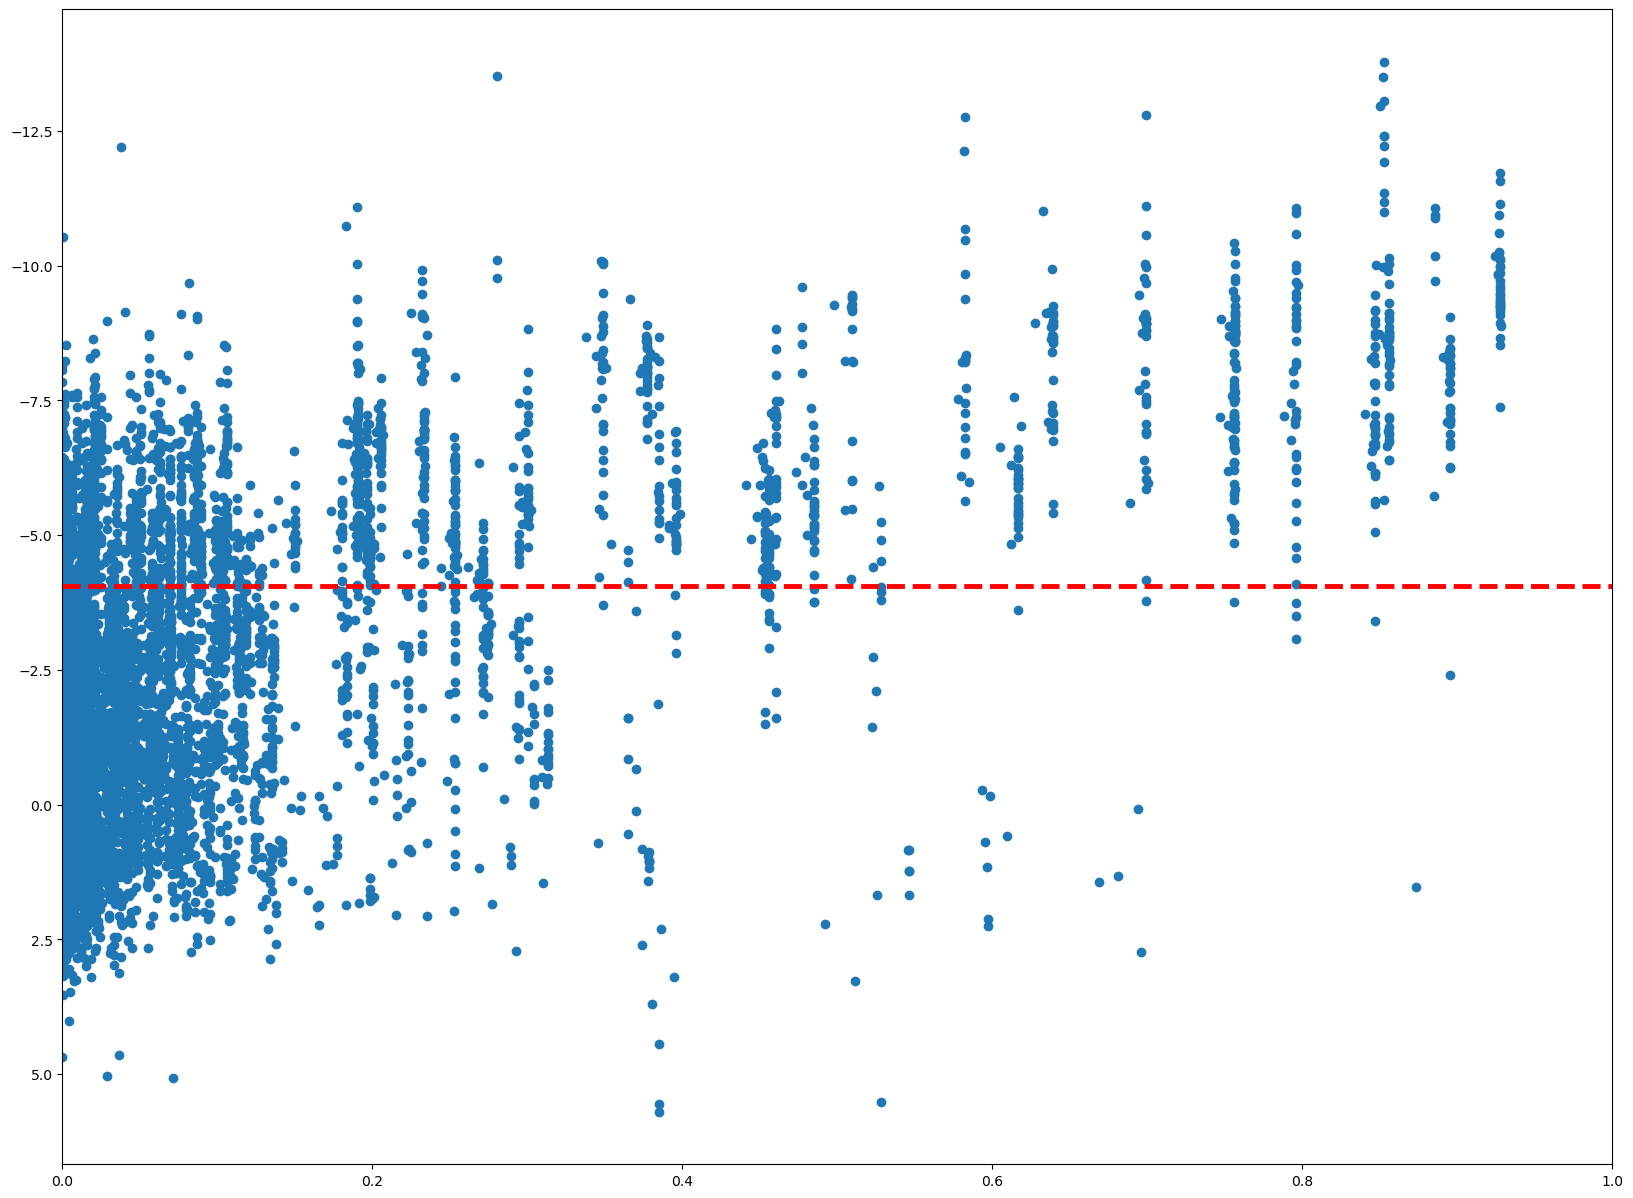

In [45]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=np.log2(testCDR.ic50))
plt.axhline(np.log2(0.06), color='red', linestyle='dashed', linewidth=3.5)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

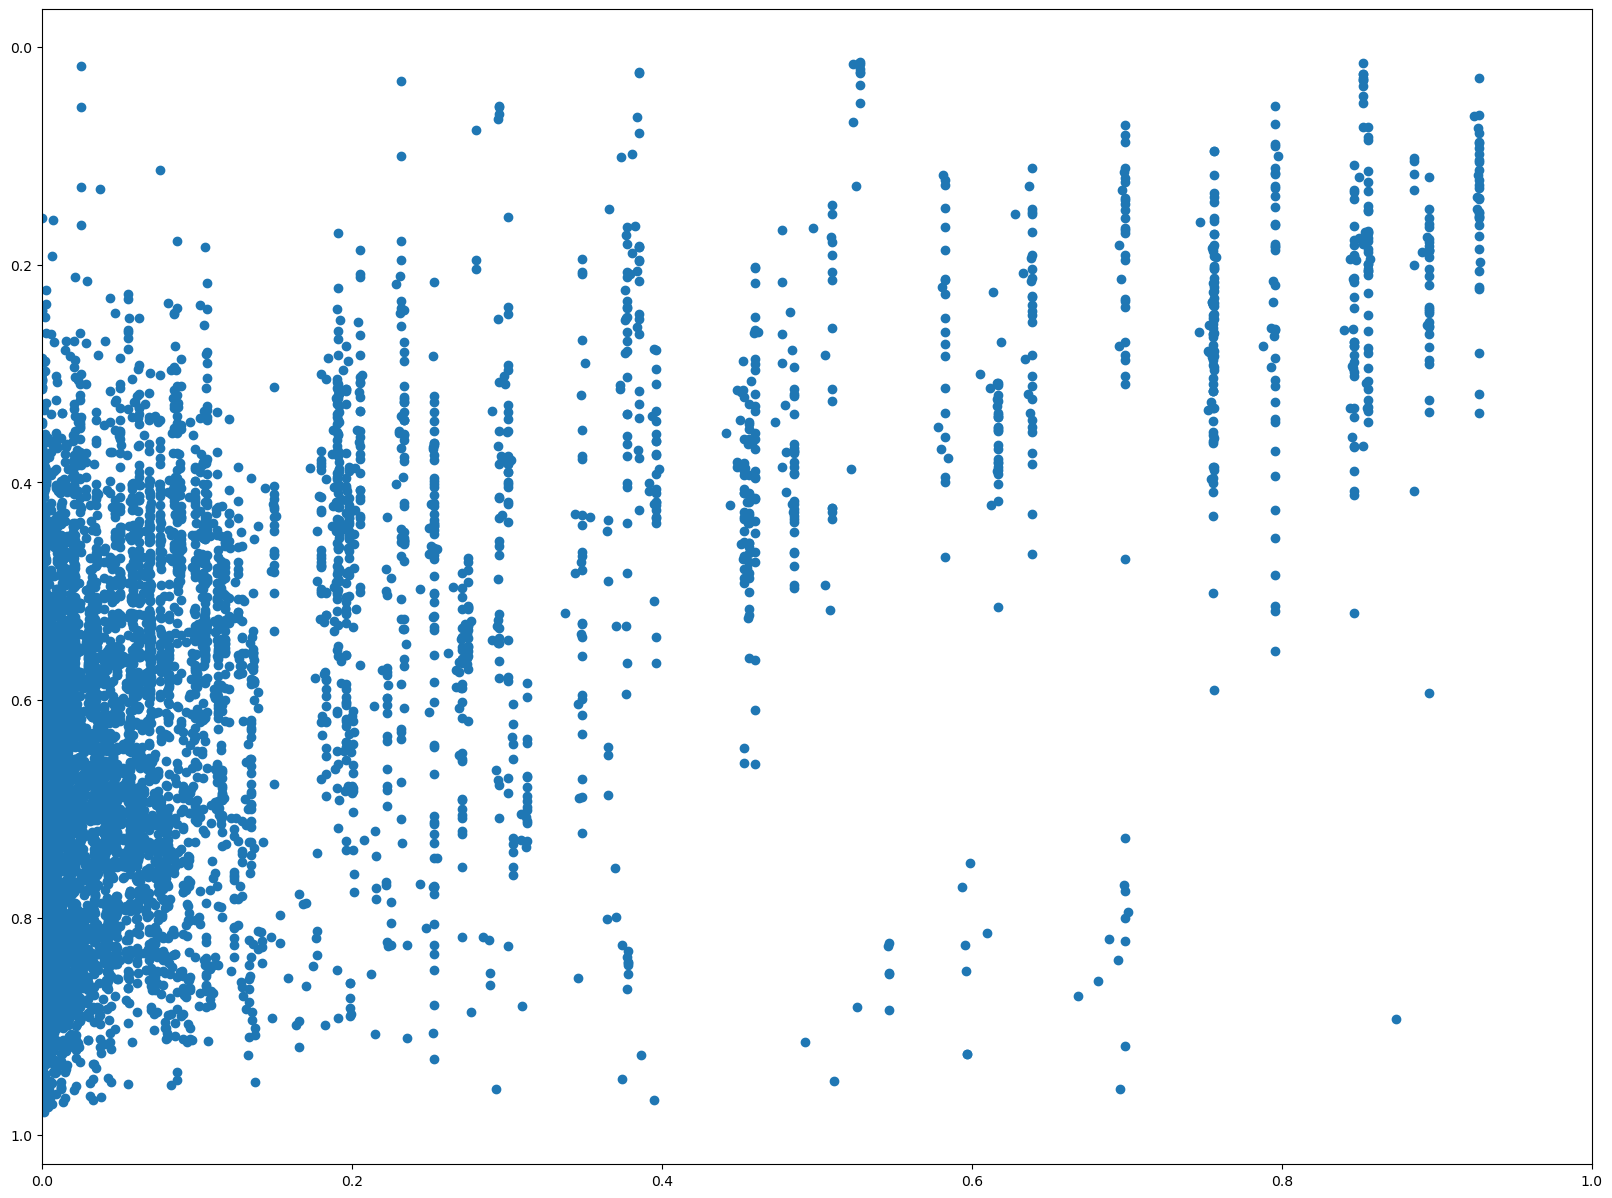

In [46]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=testCDR.auc)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

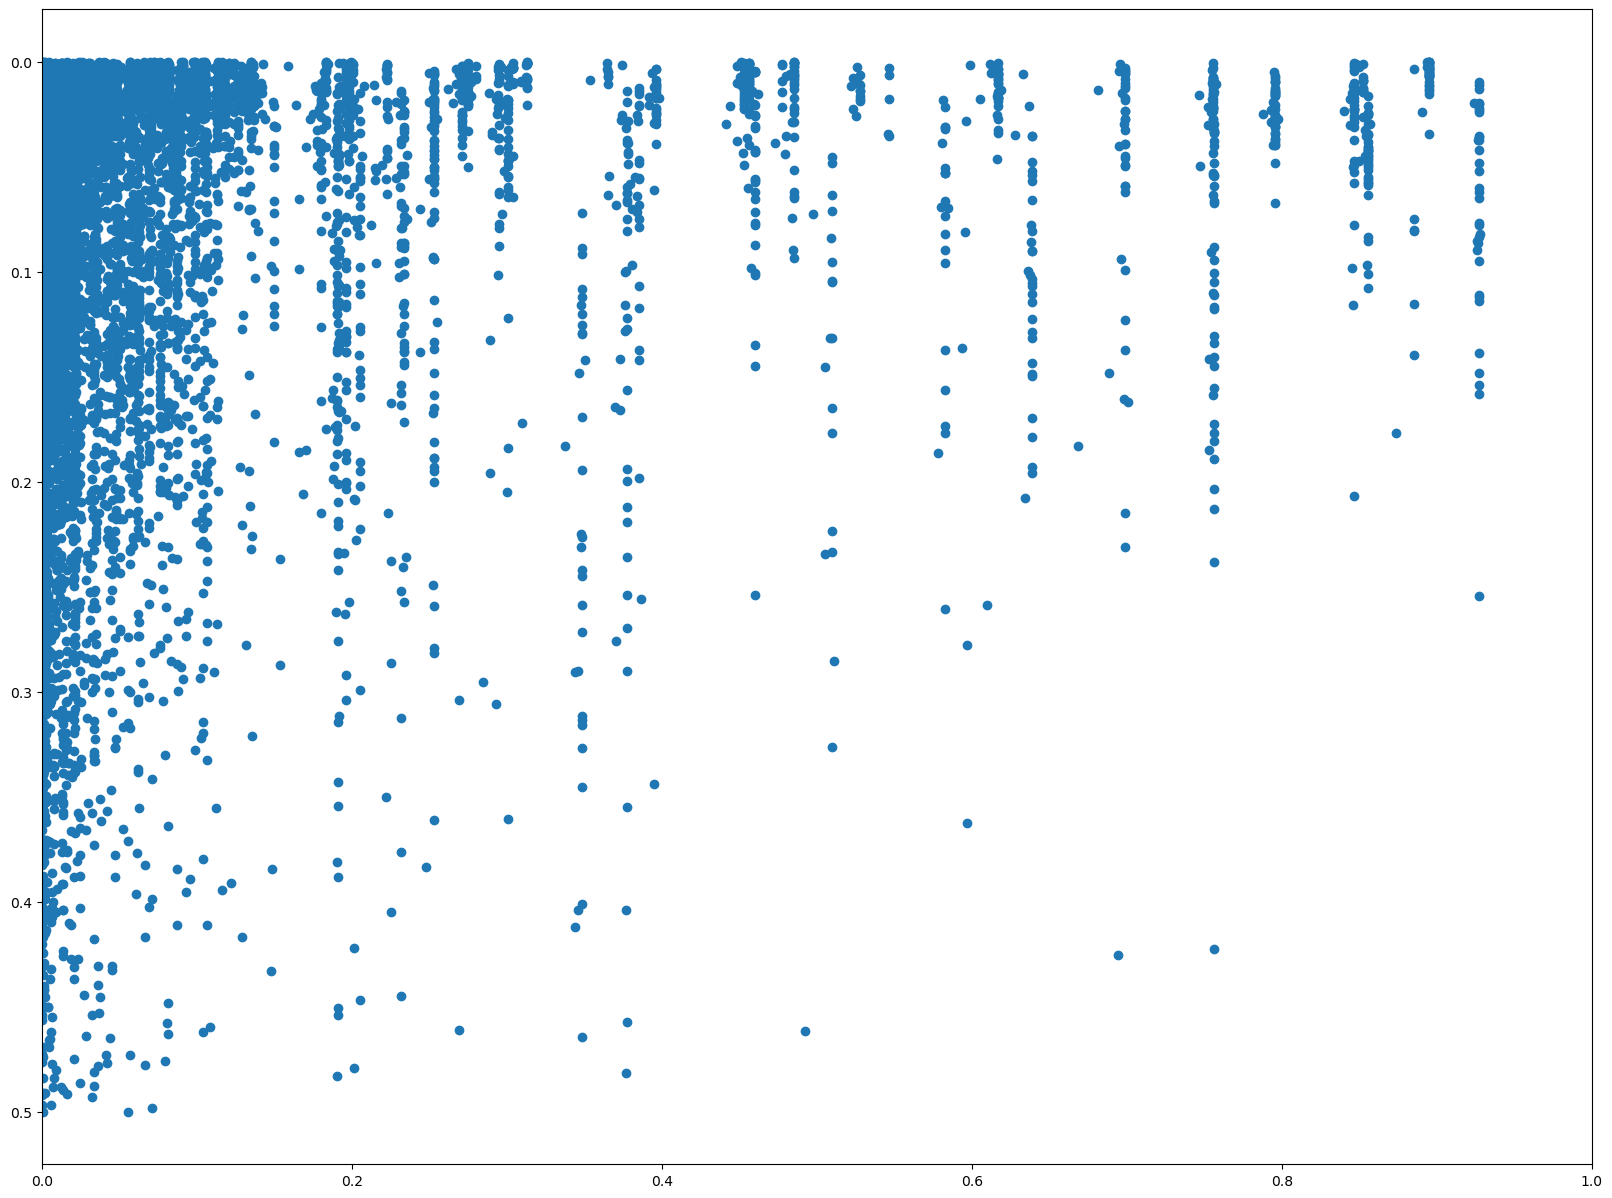

In [49]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=testCDR.lower_limit)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

In [56]:
testCount, testWrong = countDrugsK(testCDR, getPcnt=True)
print(testCount.pcntCorrect.mean())
testCount.sort_values(by='total', ascending=False)

0.42393429910053954


,1,2,3,total,pcntCorrect
dolastatin-10,35,0,0,69,0.492754
echinomycin,4,14,19,68,0.455882
romidepsin,10,22,0,63,0.492063
10-hydroxycamptothecin,2,3,10,26,0.423077
YM-155,0,4,5,15,0.400000
triptolide,0,2,5,14,0.500000
maytansinol-isobutyrate,0,3,3,12,0.500000
genz-644282,0,1,3,7,0.428571
epothilone-b,0,2,2,6,0.333333
BGT226,0,0,2,3,0.333333


In [57]:
len(testCount)

15

In [52]:
newCDR['pred'] = [p[1] for p in lm.predict_proba(newData)]
newCDR.sort_values(by='pred', ascending=False, inplace=True)

<ipython-input-52-93c1713698e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR['pred'] = [p[1] for p in lm.predict_proba(newData)]
<ipython-input-52-93c1713698e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR.sort_values(by='pred', ascending=False, inplace=True)


In [53]:
len(set(newCDR[newCDR.pred >= 0.5].drug))

28

In [54]:
len(set(newCDR[(newCDR.pred >= 0.5) & (newCDR.true == 1)].drug))

17

In [55]:
newCDR[newCDR.pred > 0.5].true.sum() / len(newCDR[newCDR.pred > 0.5])

0.7826825127334465

In [58]:
newCount, newWrong = countDrugsK(newCDR, getPcnt=True)
print(newCount.pcntCorrect.mean())
newCount.sort_values(by='total', ascending=False)

No true effective drugs identified in top 3 for ACH-000268 (top drug: sangivamycin)
0.3366731819560181


,1,2,3,total,pcntCorrect
dolastatin-10,46,0,0,91,0.494505
echinomycin,7,15,26,91,0.472527
romidepsin,12,34,1,89,0.471910
maytansinol-isobutyrate,0,6,9,30,0.500000
10-hydroxycamptothecin,0,5,11,29,0.448276
triptolide,1,2,5,16,0.500000
YM-155,0,2,4,11,0.454545
genz-644282,0,1,4,8,0.375000
epothilone-b,0,0,4,6,0.333333
gemcitabine,0,0,1,2,0.500000
